# Masksembles for probablistic regression

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from scipy.stats import norm

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense

from masksembles.keras import Masksembles1D

## Usecase: linear RUL with masksembles

**Define the data function and parameter limits**

In [88]:
# Define linear function
def func(x, a, c, noise_amp = 0):
    y = a*x + c
    y = y + noise_amp * np.random.randn(len(x))
    return y

**Previous model (Deterministic)**

In [89]:
model = Sequential()
model.add(Dense(64, input_dim=100, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

**New model with masksembles**

In [90]:
np.random.seed(2049)

def create_dataset(x, n_training_obs=1000):

    x = np.arange(0,10,0.1)
    a_range = (0, 2)
    c_range = (0, 10)
    noise_range = (0,5)

    a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
    c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
    noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

    targets = np.array(list(zip(a_list,c_list)))
    targets_with_noise = np.array(list(zip(a_list,c_list,noise_list)))
    features = np.array([func(x,a,c,noise) for a, c, noise in targets_with_noise])

    return features, targets, noise_list

x = np.arange(0,10,0.1)
features, targets, noise_list = create_dataset(x, 10000)

In [91]:
batch_size = 100

input_layer = Input(shape=(100,))
layer_x = Dense(100, activation='relu')(input_layer)
layer_x = Masksembles1D(100, 2.0)(layer_x)
layer_x = Dense(50, activation='relu')(layer_x)
layer_x = Masksembles1D(100, 2.0)(layer_x)
layer_x = Dense(25, activation='relu')(layer_x)
layer_x = Masksembles1D(100, 2.0)(layer_x)
output_layer = Dense(2, activation='linear')(layer_x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(features, targets, epochs=50, batch_size=batch_size, verbose=0, shuffle=False)

plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

Epoch 1/50
100/100 [==============================] - 1s 2ms/step - loss: 5.9051
Epoch 2/50
100/100 [==============================] - 0s 2ms/step - loss: 1.4390
Epoch 3/50
100/100 [==============================] - 0s 2ms/step - loss: 0.8576
Epoch 4/50
100/100 [==============================] - 0s 3ms/step - loss: 0.6347
Epoch 5/50
100/100 [==============================] - 0s 2ms/step - loss: 0.5123
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 0.4482
Epoch 7/50
100/100 [==============================] - 0s 2ms/step - loss: 0.4043
Epoch 8/50
100/100 [==============================] - 0s 2ms/step - loss: 0.3704
Epoch 9/50
100/100 [==============================] - 0s 2ms/step - loss: 0.3413
Epoch 10/50
100/100 [==============================] - 0s 2ms/step - loss: 0.3181
Epoch 11/50
100/100 [==============================] - 0s 2ms/step - loss: 0.2979
Epoch 12/50
100/100 [==============================] - 0s 2ms/step - loss: 0.2809
Epoch 13/50
100/100 [====

### Test the model

In [92]:
test_features = np.array([[1,2,3],[4,5,6]])
np.repeat(test_features, 2, axis=0)

array([[1, 2, 3],
       [1, 2, 3],
       [4, 5, 6],
       [4, 5, 6]])

In [93]:
features, targets, noise_list = create_dataset(x, 10000)
feature_stack = np.repeat(features, batch_size, axis=0)

y_pred = model.predict(feature_stack, batch_size=batch_size)
y_pred.shape

(1000000, 2)

In [94]:
y_pred = y_pred.reshape(-1, batch_size, 2)
y_pred.shape

(10000, 100, 2)

In [95]:
y_pred[0][:10]

array([[0.6133941 , 8.5735235 ],
       [0.51073146, 8.965924  ],
       [0.668857  , 8.947621  ],
       [0.35715193, 8.5394125 ],
       [0.62530124, 8.632173  ],
       [0.5373038 , 8.692226  ],
       [0.6700896 , 8.294566  ],
       [0.5098187 , 8.775812  ],
       [0.60626805, 8.4056835 ],
       [0.5625422 , 8.77023   ]], dtype=float32)

In [96]:
y_pred[1][:10]

array([[0.20952788, 1.4945703 ],
       [0.3855365 , 3.0627434 ],
       [0.17679259, 1.8967155 ],
       [0.1197625 , 2.0816698 ],
       [0.38081884, 1.3072103 ],
       [0.08380209, 0.9326965 ],
       [0.29793555, 0.9124369 ],
       [0.2751809 , 1.3907208 ],
       [0.4301076 , 2.05024   ],
       [0.42095646, 1.6283617 ]], dtype=float32)

In [106]:
a_mean = y_pred[:,:,0].mean(axis=1)
a_std = y_pred[:,:,0].std(axis=1)

c_mean = y_pred[:,:,1].mean(axis=1)
c_std = y_pred[:,:,1].std(axis=1)

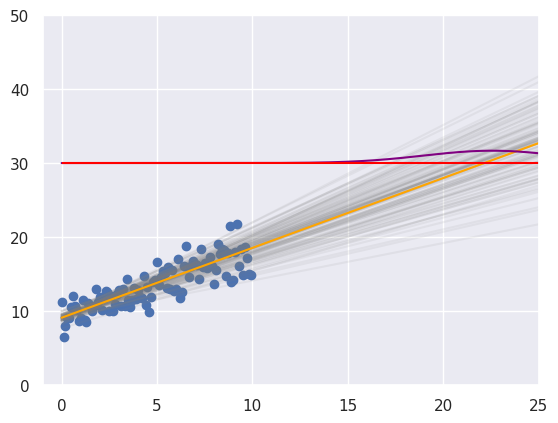

In [113]:
idx = 6

limit = 30
x30 = np.arange(0,30,0.1)
rul_list = []


for a, c in y_pred[idx]:
    y_pred_idx = func(x30, a, c)
    plt.plot(x30, y_pred_idx, color='grey', alpha=0.1)
    idx_rul = np.abs(y_pred_idx - limit).argmin()
    rul = x30[idx_rul]
    rul_list.append(rul)

y_pred_mean = func(x30, a_mean[idx], c_mean[idx])
plt.plot(x30, y_pred_mean, color='orange')

rul_list = np.array(rul_list)
rul_mean = rul_list.mean()
rul_std = rul_list.std()
rul_pdf = norm.pdf(x30, rul_mean, rul_std)
plt.plot(x30, (rul_pdf*15)+30, color='purple')

plt.hlines(limit, 0, 30, color='red')
plt.scatter(x, features[idx])

plt.xlim(-1,25)
plt.ylim(0,50)
plt.show()

## Make the model more complex

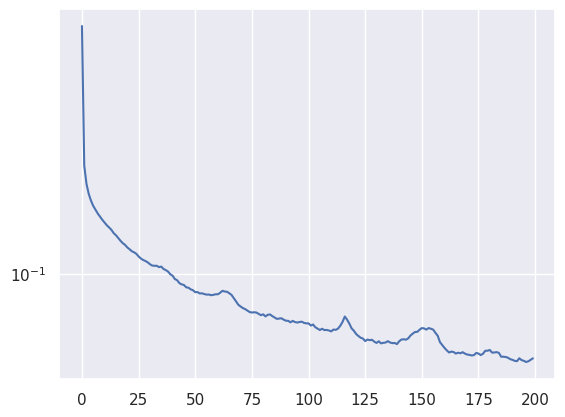

In [118]:
%%time

x = np.arange(0,10,0.1)
features, targets, noise_list = create_dataset(x, 50000)

batch_size = 100

input_layer = Input(shape=(100,))
layer_x = Dense(200, activation='relu')(input_layer)
layer_x = Masksembles1D(100, 2.0)(layer_x)
layer_x = Dense(100, activation='relu')(layer_x)
layer_x = Masksembles1D(100, 2.0)(layer_x)
layer_x = Dense(50, activation='relu')(layer_x)
layer_x = Masksembles1D(100, 2.0)(layer_x)
output_layer = Dense(2, activation='linear')(layer_x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(features, targets, epochs=200, batch_size=batch_size, verbose=0, shuffle=False)

plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

**Test the model**

In [119]:
%%time

features, targets, noise_list = create_dataset(x, 10000)
feature_stack = np.repeat(features, batch_size, axis=0)

y_pred = model.predict(feature_stack, batch_size=batch_size)
y_pred = y_pred.reshape(-1, batch_size, 2)

a_mean = y_pred[:,:,0].mean(axis=1)
a_std = y_pred[:,:,0].std(axis=1)

c_mean = y_pred[:,:,1].mean(axis=1)
c_std = y_pred[:,:,1].std(axis=1)

CPU times: user 14.9 s, sys: 3.91 s, total: 18.8 s
Wall time: 14.3 s


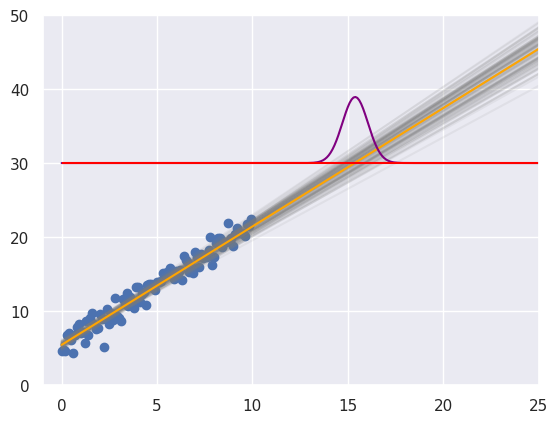

In [121]:
idx = 1

limit = 30
x30 = np.arange(0,30,0.1)
rul_list = []


for a, c in y_pred[idx]:
    y_pred_idx = func(x30, a, c)
    plt.plot(x30, y_pred_idx, color='grey', alpha=0.1)
    idx_rul = np.abs(y_pred_idx - limit).argmin()
    rul = x30[idx_rul]
    rul_list.append(rul)

y_pred_mean = func(x30, a_mean[idx], c_mean[idx])
plt.plot(x30, y_pred_mean, color='orange')

rul_list = np.array(rul_list)
rul_mean = rul_list.mean()
rul_std = rul_list.std()
rul_pdf = norm.pdf(x30, rul_mean, rul_std)
plt.plot(x30, (rul_pdf*15)+30, color='purple')

plt.hlines(limit, 0, 30, color='red')
plt.scatter(x, features[idx])

plt.xlim(-1,25)
plt.ylim(0,50)
plt.show()